In [1]:
import os.path
import numpy as np
import pandas as pd
import time
from datetime import datetime

import shtReader_py.shtRipper as shtRipper
from source.Files_operating import read_dataFile
from source.NN_environment import process_fragments, get_borders, normalise_series, down_to_zero
from source.NN_environment import get_prediction_unet

shtRipper v1.3


In [4]:
F_ID = 44183

df =  pd.read_csv(f"data/intervals/df/{F_ID}_data.csv", sep=",")
df.describe()

,t,ch1,ch1_marked,ch1_ai_marked
count,393216.000000,393216.000000,393216.000000,3.932160e+05
mean,0.196607,0.278200,0.003807,1.622242e-02
std,0.113512,0.438119,0.061584,1.158897e-01
min,0.000000,-0.743840,0.000000,0.000000e+00
25%,0.098304,0.012781,0.000000,1.101469e-29
50%,0.196607,0.058792,0.000000,1.767655e-16
75%,0.294911,0.554685,0.000000,5.596657e-10
max,0.393215,4.843909,1.000000,1.000000e+00


In [2]:
interval_path = "data/intervals/"
signal_path = "data/d-alpha/"
sht_path = "data/sht/"

filename = "sht44350"
F_ID = filename[-5:]

# if os.path.isfile(signal_path + f"df/{F_ID}_data.csv"):
#     df = pd.read_csv(signal_path + f"df/{F_ID}_data.csv", sep=",")
# elif os.path.isfile(interval_path + f"df/{F_ID}_data.csv"):
#     df = pd.read_csv(interval_path + f"df/{F_ID}_data.csv", sep=",")
# else:
df = read_dataFile(interval_path + filename + "_exportGlobus2.dat", F_ID)
df["ch1_marked"] = pd.Series([0] * df.shape[0])
df["ch1_ai_marked"] = pd.Series([0] * df.shape[0])

df.describe()

,t,ch1,ch1_marked,ch1_ai_marked
count,55376.000000,55376.000000,55376.0,55376.0
mean,182.648500,0.456791,0.0,0.0
std,15.985819,0.167452,0.0,0.0
min,154.961000,0.191710,0.0,0.0
25%,168.804750,0.337410,0.0,0.0
50%,182.648500,0.419210,0.0,0.0
75%,196.492250,0.534240,0.0,0.0
max,210.336000,1.395700,0.0,0.0


Input visualising mode [ 0 - manual | 1 - only marked ]: 0
Input marking mode (0 - manual | 1 - semiauto):  1
Input start index [0:55000]:  36000


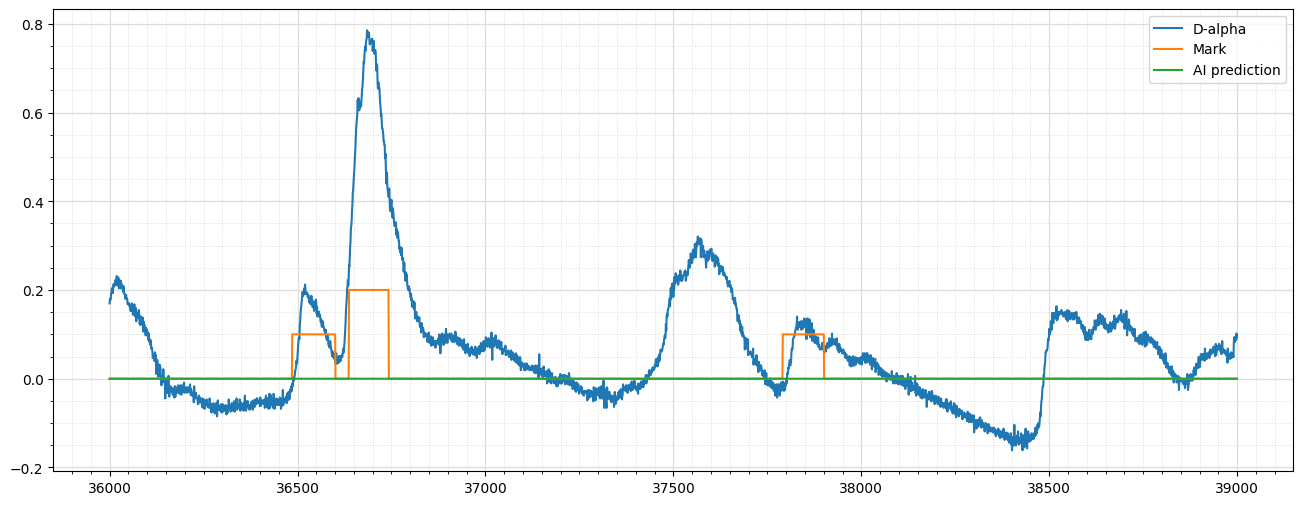

Input index pairs of ELM fragments (190.961 - 193.961 ms):
 38450 38600
Input mark to set [ 0 | 1 | 2 ]:  1


<Figure size 640x480 with 0 Axes>

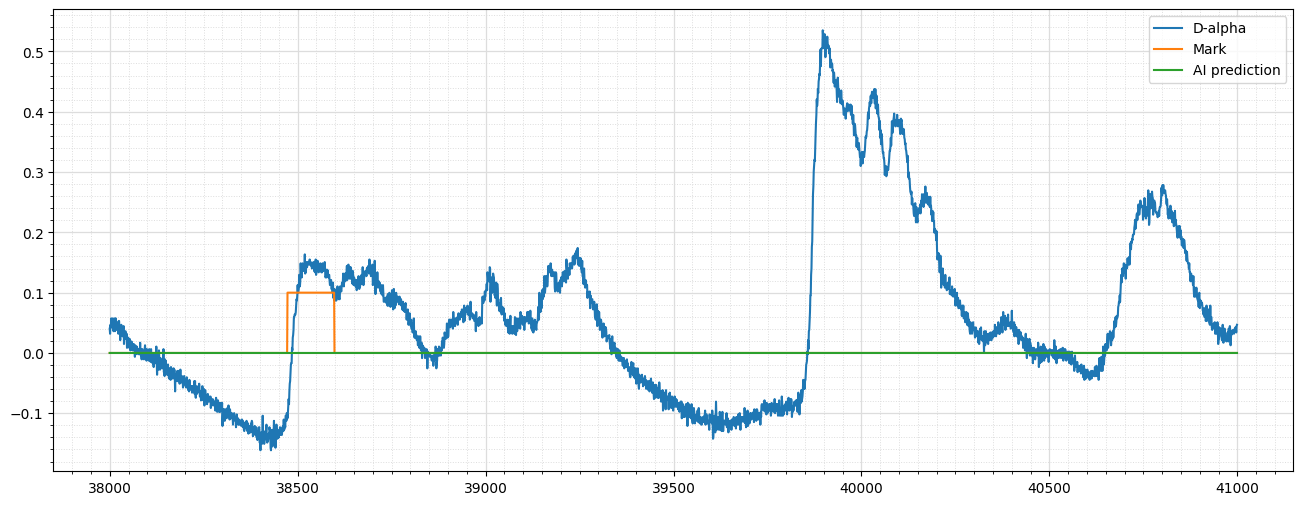

Input index pairs of ELM fragments (192.961 - 195.961 ms):
 39800 40250
Input mark to set [ 0 | 1 | 2 ]:  2


<Figure size 640x480 with 0 Axes>

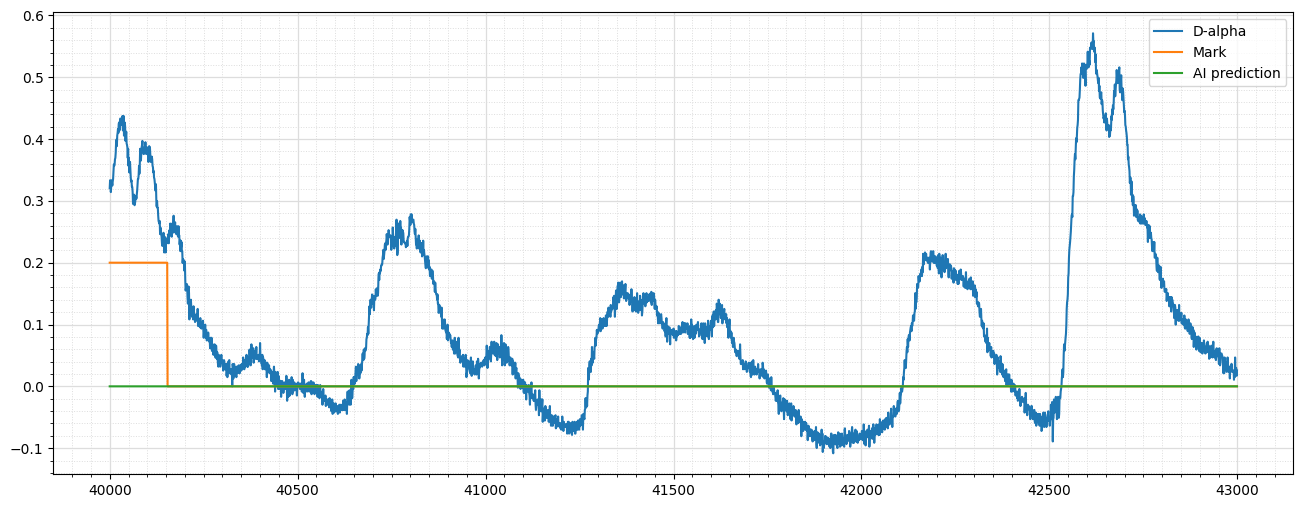

Input index pairs of ELM fragments (194.961 - 197.961 ms):
 42500 42800
Input mark to set [ 0 | 1 | 2 ]:  2


<Figure size 640x480 with 0 Axes>

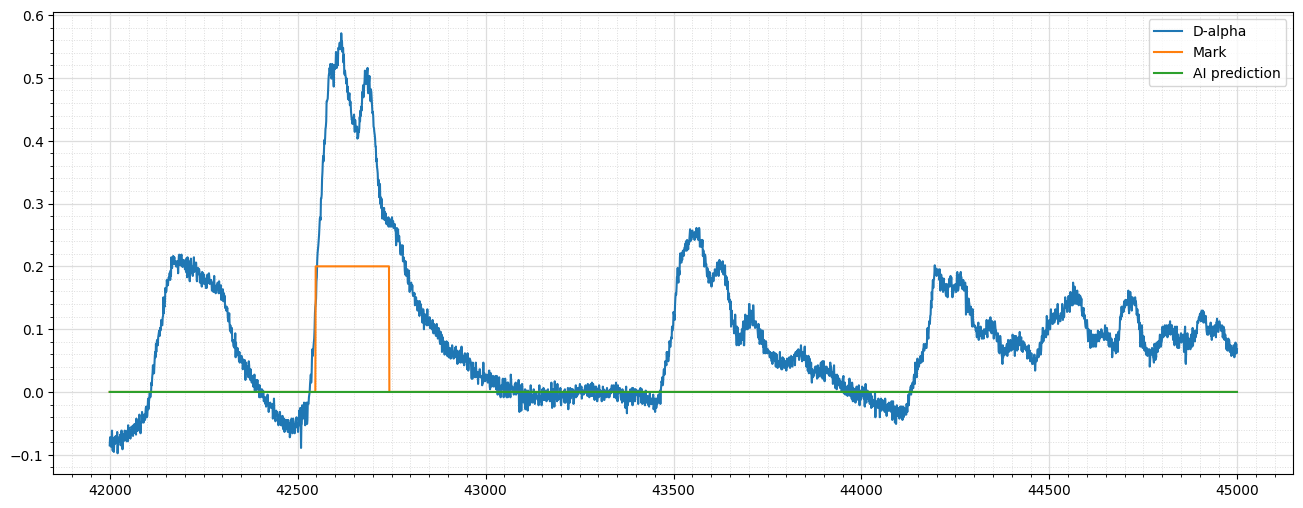

Input index pairs of ELM fragments (196.961 - 199.961 ms):
 42000 42350 43450 43600
Input mark to set [ 0 | 1 | 2 ]:  1
Input mark to set [ 0 | 1 | 2 ]:  1


<Figure size 640x480 with 0 Axes>

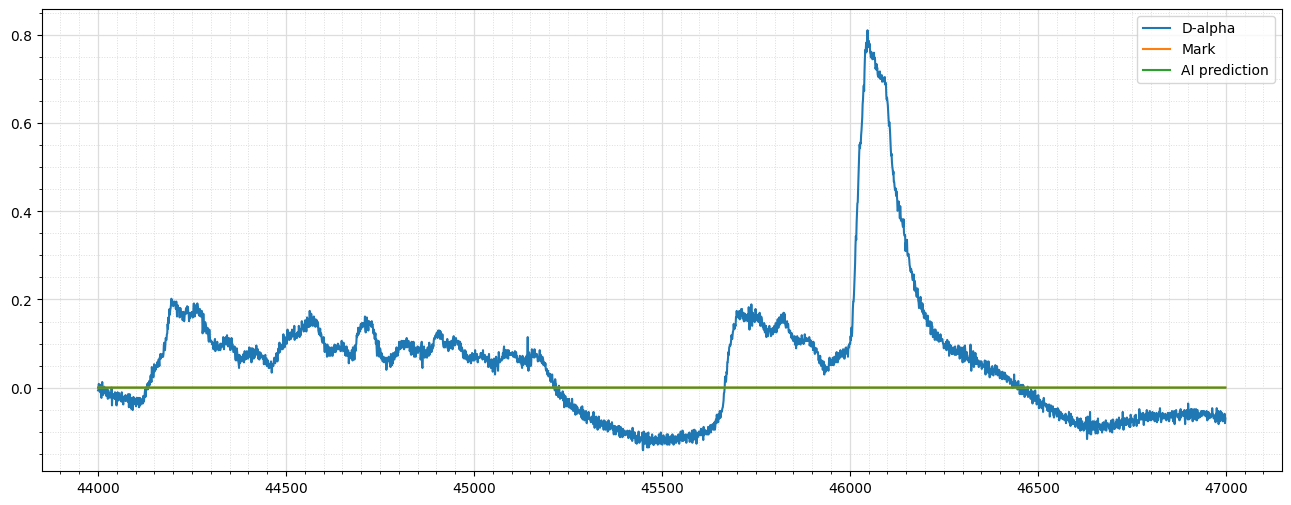

Input index pairs of ELM fragments (198.961 - 201.961 ms):
 45650 45800 45950 46200
Input mark to set [ 0 | 1 | 2 ]:  1
Input mark to set [ 0 | 1 | 2 ]:  2


<Figure size 640x480 with 0 Axes>

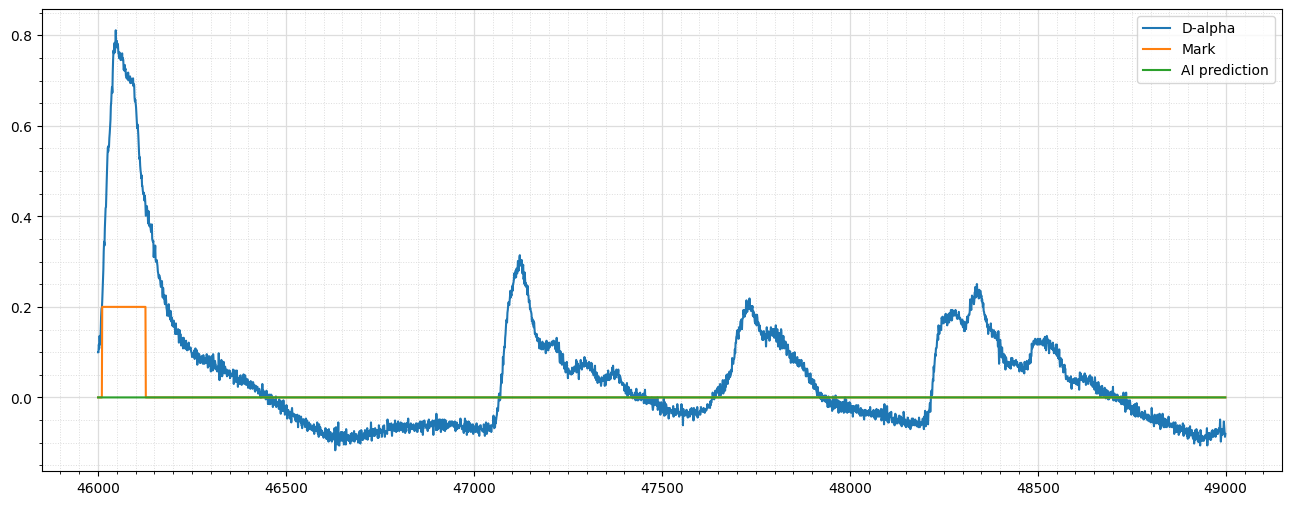

Input index pairs of ELM fragments (200.961 - 203.961 ms):
 47000 47150 48200 48400
Input mark to set [ 0 | 1 | 2 ]:  1
Input mark to set [ 0 | 1 | 2 ]:  1


<Figure size 640x480 with 0 Axes>

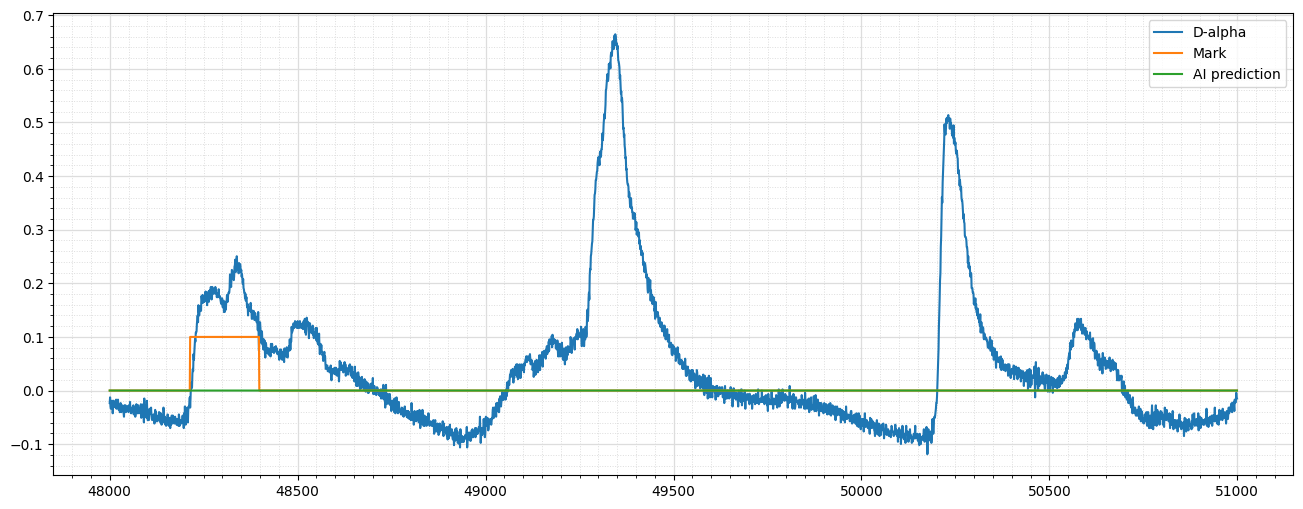

Input index pairs of ELM fragments (202.961 - 205.961 ms):
 49250 49500
Input mark to set [ 0 | 1 | 2 ]:  2


<Figure size 640x480 with 0 Axes>

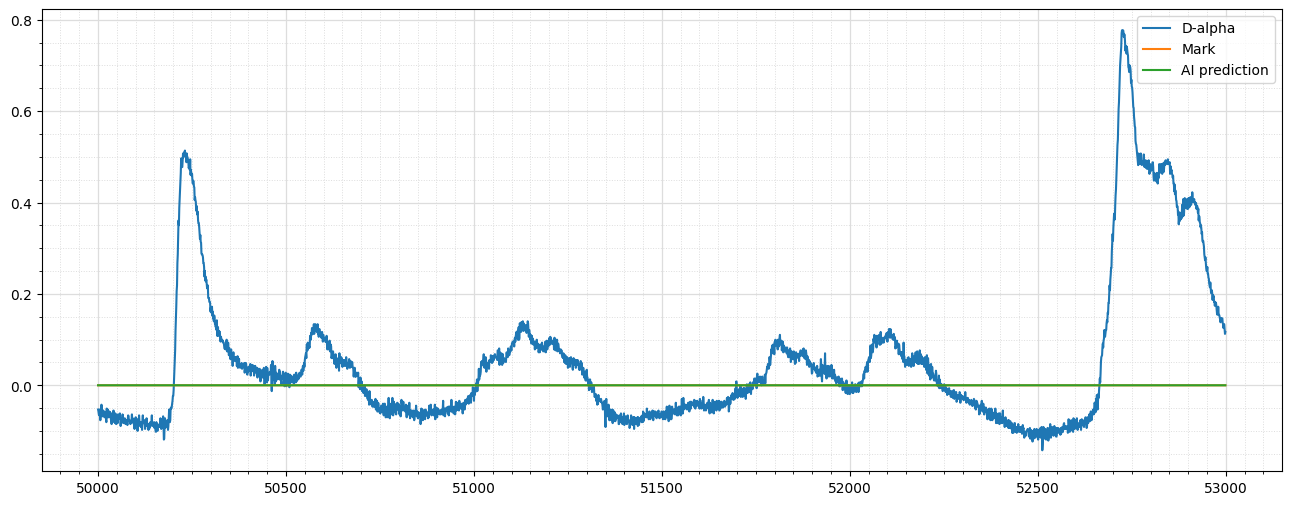

Input index pairs of ELM fragments (204.961 - 207.961 ms):
 50000 50300  50500 50650 51750 51850 52000 52150
Input mark to set [ 0 | 1 | 2 ]:  1
Input mark to set [ 0 | 1 | 2 ]:  1
Input mark to set [ 0 | 1 | 2 ]:  1
Input mark to set [ 0 | 1 | 2 ]:  1


<Figure size 640x480 with 0 Axes>

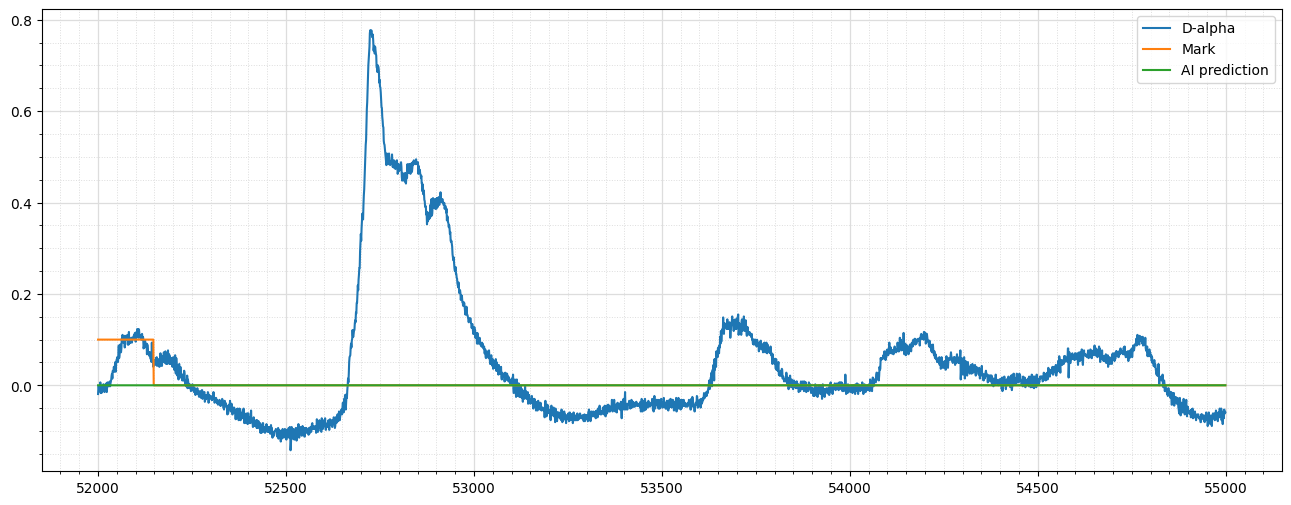

Input index pairs of ELM fragments (206.961 - 209.961 ms):
 52500 53000 53600 53800 54050 54110
Input mark to set [ 0 | 1 | 2 ]:  2
Input mark to set [ 0 | 1 | 2 ]:  1
Input mark to set [ 0 | 1 | 2 ]:  1


<Figure size 640x480 with 0 Axes>

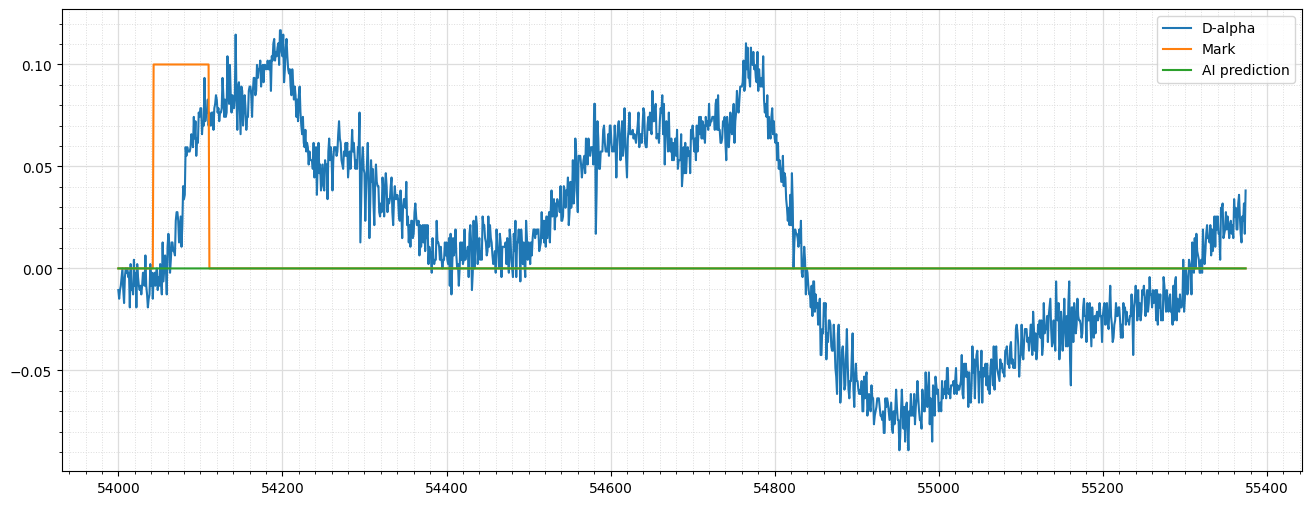

Input index pairs of ELM fragments (208.961 - 210.336 ms):
 54000 54250
Input mark to set [ 0 | 1 | 2 ]:  1


<Figure size 640x480 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

mode_ploting = int(input("Input visualising mode [ 0 - manual | 1 - only marked ]:"))
mode_marking = int(input("Input marking mode (0 - manual | 1 - semiauto): ").strip().split()[0])
l_edge = int(input(f"Input start index [0:{df.shape[0]//1000*1000}]: ").strip().split()[0])
# print("---")
step = 2000
width = 3000

step_away = 10

while l_edge < df.shape[0]:
    r_edge = min(l_edge + width, df.shape[0] - 1)
    
    if mode_ploting == 1 and sum(df.ch1_marked[l_edge:r_edge]) == 0:
        l_edge += step
        continue
    
    fig, ax = plt.subplots()

    fig.set_figwidth(16)
    fig.set_figheight(6)

    ax.plot(range(l_edge, r_edge), normalise_series(df.ch1)[l_edge:r_edge], label="D-alpha")
    ax.plot(range(l_edge, r_edge), df.ch1_marked[l_edge:r_edge] * 0.1, label="Mark")
    ax.plot(range(l_edge, r_edge), df.ch1_ai_marked[l_edge:r_edge] * 0.1, label="AI prediction")

    ax.grid(which='major', color='#DDDDDD', linewidth=0.9)
    ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.legend()
    plt.show()

    res = list(map(int, input(f"Input index pairs of ELM fragments ({df.t[l_edge]} - {df.t[r_edge]} ms):\n").strip().split()))
    for i in range(0, len(res), 2):
        board_ind = [res[i], res[i+1]]

        mark = float(input("Input mark to set [ 0 | 1 | 2 ]: "))
        
        if mode_marking and mark > 0:
            board_ind = get_borders(df.loc[res[i]:res[i + 1], "ch1"].to_numpy(), scale=1.5)
            board_ind[0] = max(board_ind[0] - step_away + res[i], 0)
            board_ind[1] += res[i]
        
        df.loc[board_ind[0]:board_ind[1], "ch1_marked"] = mark

    plt.close()
    plt.clf()
    l_edge += step

# 217500

In [7]:
df.to_csv(interval_path + f"df/{F_ID}_data.csv", index=False)
df.describe()

,t,ch1,ch1_marked,ch1_ai_marked
count,55376.000000,55376.000000,55376.000000,55376.0
mean,182.648500,0.456791,0.226289,0.0
std,15.985819,0.167452,0.523081,0.0
min,154.961000,0.191710,0.000000,0.0
25%,168.804750,0.337410,0.000000,0.0
50%,182.648500,0.419210,0.000000,0.0
75%,196.492250,0.534240,0.000000,0.0
max,210.336000,1.395700,2.000000,0.0


In [15]:
count = 0
np_marked = df.ch1_marked.to_numpy()
for i in range(df.shape[0]-1):
    if np_marked[i] == 0 and np_marked[i+1] != 0:
        count += 1
print(count)

87


### Fragments info


1. 44173 - [ -- | 64 | 21 ]
2. 44183 - [ -- | 59 | 17 ]
3. 44184 - [ 57 | -- | -- ]
4. 44194 - [ 87 | -- | -- ]
5. 44350 - [ -- | 58 | 26 ]
6. 44351 - [ -- | 44 | 21 ]

---
## AI marking
---

In [4]:
from source.NN_environment import get_prediction_unet

df["ch1_ai_marked"] = get_prediction_unet(df["ch1"].to_numpy(), ckpt_v=2)  # , old=True
df.to_csv(interval_path + f"df/{F_ID}_data.csv", index=False)
df.describe()

D:\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


,t,ch1,ch1_marked,ch1_ai_marked
count,76243.000000,76243.000000,76243.0,7.624300e+04
mean,203.119000,0.529203,0.0,1.001058e-01
std,22.009603,0.160735,0.0,2.752408e-01
min,164.998000,0.181490,0.0,2.584950e-17
25%,184.058500,0.396200,0.0,9.571570e-08
50%,203.119000,0.526570,0.0,6.554467e-06
75%,222.179500,0.639040,0.0,1.165128e-03
max,241.240000,1.265300,0.0,1.000000e+00


---
## Export to SHT
---

In [10]:
F_ID = 44351

df =  pd.read_csv(f"data/intervals/df/{F_ID}_data.csv", sep=",")
df.describe()

,t,ch1,ch1_marked,ch1_ai_marked
count,393216.000000,393216.000000,393216.000000,3.932160e+05
mean,0.196607,0.183800,0.003525,1.388237e-02
std,0.113512,0.276314,0.059265,1.087089e-01
min,0.000000,-0.539348,0.000000,0.000000e+00
25%,0.098304,0.015337,0.000000,2.042218e-31
50%,0.196607,0.048567,0.000000,6.961260e-20
75%,0.294911,0.350193,0.000000,2.173595e-12
max,0.393215,4.889919,1.000000,1.000000e+00


In [12]:
import shtReader_py.shtRipper as shtRipper

to_pack = {
    "D-alpha, chord=50 cm": {
        'comment': f'SHOT: #{F_ID}',
        'unit': 'U(V)',
        'tMin': df.t.min(),  # minimum time
        'tMax': df.t.max(),  # maximum time
        'offset': 0.0,  # ADC zero level offset
        'yRes': 0.0001,  # ADC resolution: 0.0001 Volt per adc bit
        'y': df.ch1.to_list()
    },
    "Mark": {
        'comment': 'ELMs marks (by Belous F.; 09.08.2024)',  # Belous F. | proc-sys v2.0-0scl
        'unit': 'U(V)',
        'tMin': df.t.min(),  # minimum time
        'tMax': df.t.max(),  # maximum time
        'offset': 0.0,  # ADC zero level offset
        'yRes': 0.0001,  # ADC resolution: 0.0001 Volt per adc bit
        'y': df.ch1_marked.to_list()
    },
    "AI prediction": {
        'comment': 'Processed NN prediction of ELMs (v3 new; trn-on: #44[168|184|194])',
        'unit': 'U(V)',
        'tMin': df.t.min(),  # minimum time
        'tMax': df.t.max(),  # maximum time
        'offset': 0.0,  # ADC zero level offset
        'yRes': 0.0001,  # ADC resolution: 0.0001 Volt per adc bit
        'y': df.ch1_ai_marked.to_list()
    },
}

packed = shtRipper.ripper.write(path="D:/Edu/Lab/D-alpha-instability-search/data/sht/marked/", filename=f'{F_ID}_eval_data.SHT', data=to_pack)  # _eval

In [3]:
# def process_fragments(data: np.array, mark_data: np.array, edge=10, scale=np.exp(1), step_out=10) -> np.array:
#     proc_slice = Slice(0, 0)
#     cur_slice = Slice(0, 1)
#     f_fragment = False
#
#     while cur_slice.r < mark_data.shape[0]:
#         if mark_data[cur_slice.r] == 1.0:
#             if not f_fragment:
#                 f_fragment = True
#         elif f_fragment:
#             if not cur_slice.check_length(edge):
#                 mark_data[cur_slice.l: cur_slice.r] = 0.0
#                 if not proc_slice.is_null():
#                     mark_data[proc_slice.l: proc_slice.r] = 1.0
#                     proc_slice.collapse_borders()
#             elif not proc_slice.collide_slices(cur_slice, edge):
#                 mark_data[proc_slice.l: proc_slice.r] = 1.0
#                 proc_slice.copy(cur_slice)
#
#             f_fragment = False
#             cur_slice.collapse_borders()
#         elif not f_fragment:
#             cur_slice.collapse_borders()
#             if not proc_slice.is_null():
#                 proc_slice.copy(cur_slice)
#
#         cur_slice.step()
#
#     return mark_data

# elif scale:
# mark_data[cur_slice.l: cur_slice.r] = 0.0
# if cur_slice.check_length(edge):
#     borders = get_borders(data[cur_slice.l: cur_slice.r], scale)
#     # print(boards)
#     borders[0] = max(borders[0] + cur_slice.l - step_out, 0)
#     borders[1] = min(borders[1] + cur_slice.l, mark_data.shape[0])

#     mark_data[borders[0]:borders[1]] = 1.0

In [4]:
# from source.NN_environment import process_fragments

df["ch1_marked"] = down_to_zero(np.array(df["ch1_ai_marked"]), edge=0.5)
df["ch1_marked"] = process_fragments(np.array(df["ch1"]), np.array(df["ch1_marked"]), scale=0)
df.describe()

,t,ch1,ch1_marked,ch1_ai_marked
count,76243.000000,76243.000000,76243.000000,7.624300e+04
mean,203.119000,0.529203,0.083365,1.001058e-01
std,22.009603,0.160735,0.276435,2.752408e-01
min,164.998000,0.181490,0.000000,2.584950e-17
25%,184.058500,0.396200,0.000000,9.571570e-08
50%,203.119000,0.526570,0.000000,6.554467e-06
75%,222.179500,0.639040,0.000000,1.165128e-03
max,241.240000,1.265300,1.000000,1.000000e+00


In [5]:
df.to_csv(interval_path + f"df/{F_ID}_data.csv", index=False)


In [40]:
df["ch1_marked"] = df["ch1_ai_marked"]
df["ch1_ai_marked"] = 0